In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import seaborn as sns

import src.metrics as metrics
import src.kernels as kernels
import src.bootstrap as boot

# Outliers (level)

In [2]:
def rej_rate_outliers(outlier, n_ls, eps_ls, nreps, eps0, bandwidth=1., dim=1, alpha=0.05):
    res = {oo: {kk: {
        "tilted": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "rbf": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "tilted_ol_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
        "tilted_ball_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
    } for kk in eps_ls} for oo in n_ls}
    res["eps_ls"] = eps_ls
    
    for n in n_ls:
        for eps in eps_ls:
            key = eps
            print("key:", key)
            ###
            mean1 = np.zeros((dim,)) # data
            mean2 = np.zeros((dim,)) # model
            
            Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
            n_outlier = max(1, int(n * eps))
            Xs[:, :n_outlier] = outlier
        
            score_fn = lambda x: - (x - mean2)
            ###
    
            for X in tqdm(Xs):                
                # tilted
                score_weight_fn = kernels.PolyWeightFunction()
                kernel0 = kernels.RBF(sigma_sq=2. * bandwidth)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                wild_boot = boot.WildBootstrap(ksd)
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["tilted"]["stat"].append(stat)
                res[n][key]["tilted"]["pval"].append(pval)
                res[n][key]["tilted"]["rej"].append(int(pval < alpha))
                res[n][key]["tilted"]["boot_stats"].append(boot_stats)
        
                # RBF
                kernel = kernels.RBF(sigma_sq=2. * bandwidth)
                
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                wild_boot = boot.WildBootstrap(ksd)
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["rbf"]["stat"].append(stat)
                res[n][key]["rbf"]["pval"].append(pval)
                res[n][key]["rbf"]["rej"].append(int(pval < alpha))
                res[n][key]["rbf"]["boot_stats"].append(boot_stats)

                # tilted ol robust
                score_weight_fn = kernels.PolyWeightFunction()
                kernel0 = kernels.RBF(sigma_sq=2. * bandwidth)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                threshold = ksd.test_threshold(n=n, eps0=eps, alpha=alpha, method="ol_robust")
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ol_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ol_robust"]["threshold"].append(threshold)
                res[n][key]["tilted_ol_robust"]["rej"].append(int(stat > threshold))

                # tilted ball robust
                score_weight_fn = kernels.PolyWeightFunction()
                kernel0 = kernels.RBF(sigma_sq=2. * bandwidth)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                threshold = ksd.test_threshold(n=n, eps0=eps0, theta="ol", alpha=alpha, method="ball_robust")
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ball_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ball_robust"]["threshold"].append(threshold)
                res[n][key]["tilted_ball_robust"]["rej"].append(int(stat > threshold))

    return res

In [116]:
np.random.seed(2024)

n = 500
n_ls = [n] # [100, 500, 1000]
eps_ls = [0.1, 0.05, 0.01, 0.005] # [0.01, 0.1]

In [117]:
outlier_ls = [0.1, 1., 10., 100.]
eps0 = 0.1
res_ol = {}
for outlier in outlier_ls:
    sub_res_ol = rej_rate_outliers(outlier, n_ls, eps_ls, eps0=eps0, nreps=100)
    res_ol[outlier] = sub_res_ol

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.05


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.005


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

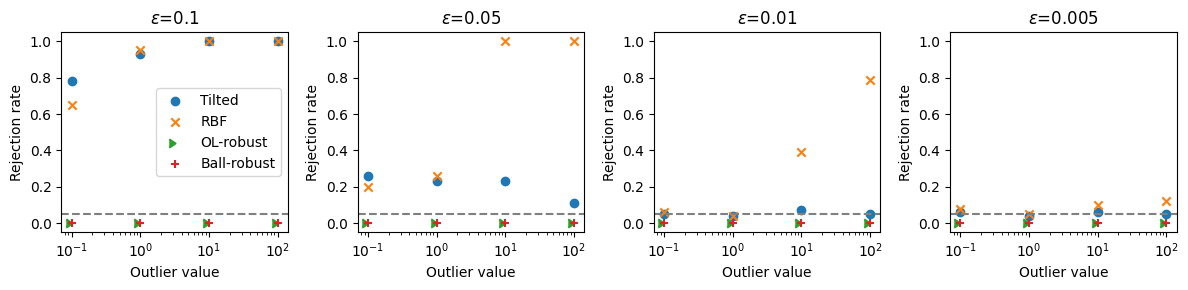

In [118]:
figs, axes = plt.subplots(ncols=len(eps_ls), nrows=1, figsize=(3*len(eps_ls), 3))

# outlier_ls = outlier_ls[::-1]
for j in range(len(eps_ls)):
    ax = axes[j]
    rej_tilted = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted"]["rej"]) for ww in outlier_ls])
    rej_rbf = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["rbf"]["rej"]) for ww in outlier_ls])
    rej_ol_robust = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted_ol_robust"]["rej"]) for ww in outlier_ls])
    rej_ball_robust = np.array([np.mean(res_ol[ww][n][eps_ls[j]]["tilted_ball_robust"]["rej"]) for ww in outlier_ls])

    ax.scatter(outlier_ls, rej_tilted, label="Tilted")
    ax.scatter(outlier_ls, rej_rbf, label="RBF", marker="x")
    ax.scatter(outlier_ls, rej_ol_robust, label="OL-robust", marker=5)
    ax.scatter(outlier_ls, rej_ball_robust, label="Ball-robust", marker="+")
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_title(rf"$\epsilon$={eps_ls[j]}")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_ylabel("Rejection rate")
    ax.set_xlabel("Outlier value")

axes.flatten()[0].legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ol.pdf")

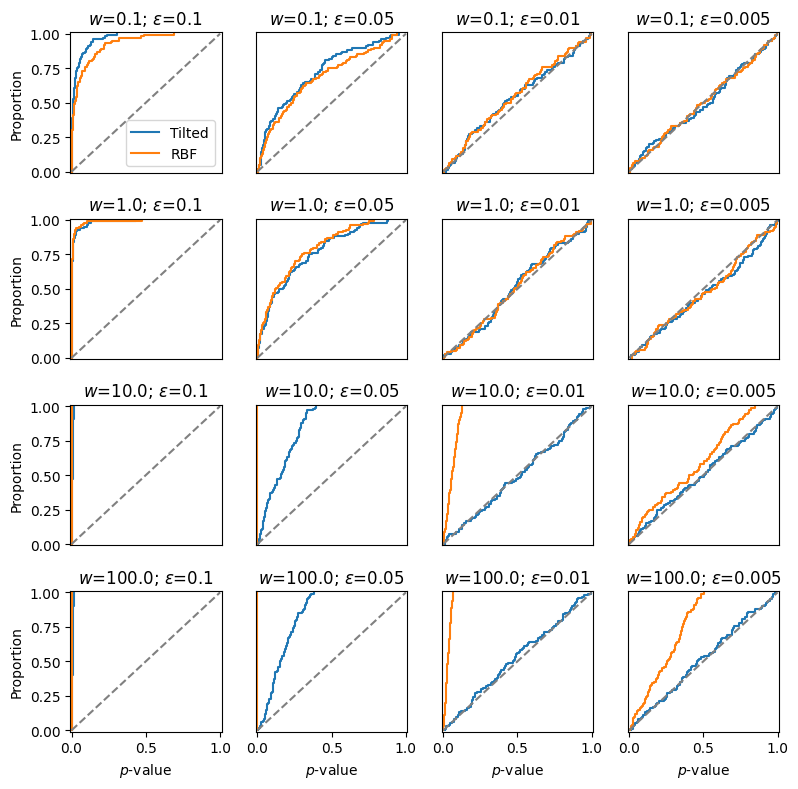

In [45]:
ncols = len(eps_ls)
nrows = len(outlier_ls)
figs, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(2*ncols, 2*nrows))

# outlier_ls_plot = outlier_ls[::-1]
for i in range(len(outlier_ls_plot)):
    for j in range(len(eps_ls)):
        ax = axes[i][j]
        sns.ecdfplot(ax=ax, x=np.array(res_ol[outlier_ls_plot[i]][n][eps_ls[j]]["tilted"]["pval"]), label="Tilted")
        sns.ecdfplot(ax=ax, x=np.array(res_ol[outlier_ls_plot[i]][n][eps_ls[j]]["rbf"]["pval"]), label="RBF")
        ax.plot([0., 1.], [0., 1.], linestyle="--", color="grey")
        ax.set_xlim(-0.01, 1.01)
        ax.set_ylim(-0.01, 1.01)
        ax.set_title(rf"$w$={outlier_ls_plot[i]}; $\epsilon$={eps_ls[j]}")
        ax.set_ylabel("")
        ax.set_xlabel("")
        
        if i < len(outlier_ls) - 1:
            ax.get_xaxis().set_ticks([])
        if j > 0:
            ax.get_yaxis().set_ticks([])
        if j == 0:
            ax.set_ylabel("Proportion")
        if i == len(outlier_ls) - 1:
            ax.set_xlabel(r"$p$-value")
        # if j == len(eps_ls) - 1:
        #     ax.twinx().set_ylabel(f"eps={eps_ls[j]}")
        #     ax.twinx().get_yaxis().set_ticks([])

axes.flatten()[0].legend(loc="lower right")
plt.tight_layout()

# Outliers vs. kernel bandwidth (level) 

In [41]:
np.random.seed(2024)

n = 500
n_ls = [n]
eps_ls = [0.01]

In [42]:
outlier_ls = [0., 1., 5., 10., 50.]
eps0 = 0.01 # oracle
bandwidth_ls = [1e-2, 1e-1, 1., 10., 100.]

res_ol_bw = {}
for ol in outlier_ls:
    print("outlier:", ol)
    res_ol_bw[ol] = {}
    
    for bw in bandwidth_ls:
        sub_res_ol = rej_rate_outliers(ol, n_ls, eps_ls, eps0=eps0, nreps=100, bandwidth=bw)
        res_ol_bw[ol][bw] = sub_res_ol

outlier: 0.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 1.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 5.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 10.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

outlier: 50.0
key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

key: 0.01


  0%|          | 0/100 [00:00<?, ?it/s]

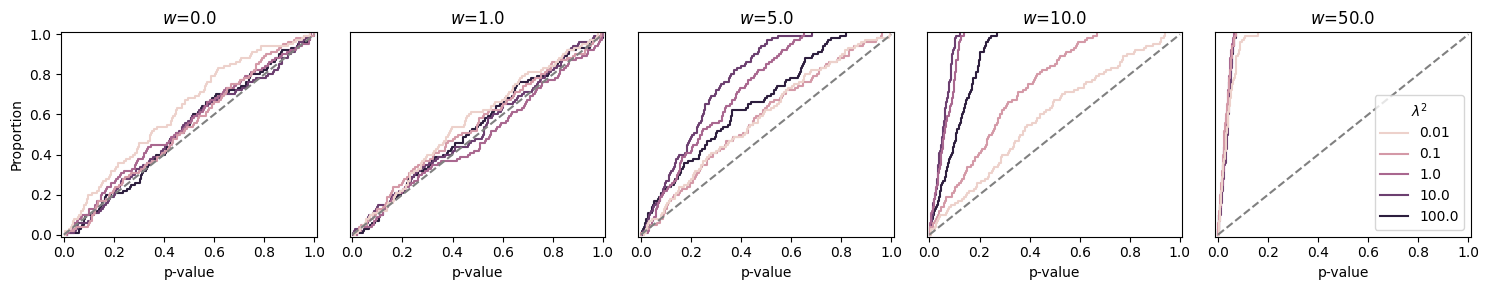

In [76]:
ncols = len(outlier_ls)
figs, axes = plt.subplots(ncols=ncols, nrows=1, figsize=(3*ncols, 3))

method_ls = ["rbf"]

for i, ax in enumerate(axes.flatten()):
    ol = outlier_ls[i]
    
    plot_df = {"pval": [], "method": [], "bw": [], "bw_order": []}
    for bw in bandwidth_ls:
        for mm in method_ls:
            rr = res_ol_bw[ol][bw][n][eps_ls[0]][mm]
            plot_df["pval"] = plot_df["pval"] + np.array(rr["pval"]).tolist()
            plot_df["method"] = plot_df["method"] + [mm] * len(rr["pval"])
            plot_df["bw"] = plot_df["bw"] + [bw] * len(rr["pval"])
            plot_df["bw_order"] = plot_df["bw_order"] + [np.round(np.log(bw) / np.log(10.), 2)] * len(rr["pval"])
    
    plot_df = pd.DataFrame(plot_df)

    # plot
    if_legend = True if i == len(axes)-1 else False
    ax_init = sns.ecdfplot(ax=ax, data=plot_df, x="pval", hue="bw_order", legend=if_legend)
    ax.plot([0., 1.], [0., 1.], linestyle="--", color="grey")
    ax.set_xlim(-0.01, 1.01)
    ax.set_ylim(-0.01, 1.01)
    ax.set_title(rf"$w$={ol}")
    ax.set_xlabel("p-value")
    if i > 0:
        ax.get_yaxis().set_ticks([])
        ax.set_ylabel("")

sns.move_legend(ax, labels=bandwidth_ls, loc="lower right", title=r"$\lambda^2$")
plt.tight_layout()
# plt.savefig("../figs/robust/standard_power_bw.pdf")

# Mean-shift (power)

In [150]:
def rej_rate_meanshift(mean_ls, n_ls, nreps, eps0=None, theta="ol", bw=2., alpha=0.05):
    res = {nn: {kk: {
        "tilted": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "rbf": {"stat": [], "pval": [], "rej": [], "boot_stats": []},
        "tilted_ol_robust": {"nonsq_stat": [], "threshold": [], "rej": []},
        "tilted_ball_robust": {"nonsq_stat": [], "threshold": [], "rej": [], "theta": []},
        "tilted_ball_clt": {"sq_stat": [], "threshold": [], "rej": [], "theta": []},
    } for kk in range(len(mean_ls))} for nn in n_ls}
    res["mean_ls"] = mean_ls


    for n in n_ls:
        for key, mean2 in enumerate(mean_ls):
            # key = mean
            print("key:", key)
            ###
            dim = mean2.shape[-1]
            mean1 = np.zeros((dim,)) # data
            # mean2 = np.reshape([mean], (-1,)) # model
            
            Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
        
            score_fn = lambda x: - (x - mean2)
            ###
            
            for X in tqdm(Xs):
                kernel_args = {"sigma_sq": None, "med_heuristic": True, "X": X, "Y": X} if bw == "med" else {"sigma_sq": bw}

                # tilted
                score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
                kernel0 = kernels.RBF(**kernel_args)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                wild_boot = boot.WildBootstrap(ksd)
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["tilted"]["stat"].append(stat)
                res[n][key]["tilted"]["pval"].append(pval)
                res[n][key]["tilted"]["rej"].append(int(pval < alpha))
                res[n][key]["tilted"]["boot_stats"].append(boot_stats)
        
                # RBF
                kernel = kernels.RBF(**kernel_args)
                
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                wild_boot = boot.WildBootstrap(ksd)
                pval, stat, boot_stats = wild_boot.pval(X, X, return_stat=True, return_boot=True)
                res[n][key]["rbf"]["stat"].append(stat)
                res[n][key]["rbf"]["pval"].append(pval)
                res[n][key]["rbf"]["rej"].append(int(pval < alpha))
                res[n][key]["rbf"]["boot_stats"].append(boot_stats)

                # tilted ol robust
                if eps0 is not None:
                    score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
                    kernel0 = kernels.RBF(**kernel_args)
                    kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
        
                    ksd = metrics.KSD(kernel, score_fn=score_fn)
                    threshold = ksd.test_threshold(n=n, eps0=eps0, alpha=alpha, method="ol_robust")
                    res[n][key]["tilted_ol_robust"]["threshold"].append(threshold)
                    stat = ksd(X, X, vstat=True) # squared-KSD
                    stat = stat**0.5
                    res[n][key]["tilted_ol_robust"]["nonsq_stat"].append(stat)
                    res[n][key]["tilted_ol_robust"]["rej"].append(int(stat > threshold))
                
                # tilted ball robust
                score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
                kernel0 = kernels.RBF(**kernel_args)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    
                ksd = metrics.KSD(kernel, score_fn=score_fn)
                threshold = ksd.test_threshold(n=n, eps0=eps0, theta=theta, alpha=alpha, method="ball_robust")
                res[n][key]["tilted_ball_robust"]["threshold"].append(threshold)
                res[n][key]["tilted_ball_robust"]["theta"].append(ksd.theta)
                stat = ksd(X, X, vstat=True) # squared-KSD
                stat = stat**0.5
                res[n][key]["tilted_ball_robust"]["nonsq_stat"].append(stat)
                res[n][key]["tilted_ball_robust"]["rej"].append(int(stat > threshold))

                # tilted ball robust CLT
                score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
                kernel0 = kernels.RBF(**kernel_args)
                kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)

                ksd = metrics.KSD(kernel, score_fn=score_fn)
                threshold = ksd.test_threshold(n=n, eps0=eps0, theta=theta, alpha=alpha, method="CLT", X=X)
                res[n][key]["tilted_ball_clt"]["threshold"].append(threshold)
                res[n][key]["tilted_ball_clt"]["theta"].append(ksd.theta)
                sq_stat = ksd(X, X, vstat=False) # squared-KSD
                res[n][key]["tilted_ball_clt"]["sq_stat"].append(sq_stat)
                res[n][key]["tilted_ball_clt"]["rej"].append(int(sq_stat > threshold))
                # res[n][key]["tilted_ball_clt"]["rej"].append(int(sq_stat > threshold))
    
    return res

In [151]:
def population_ksd_ms(mean, bandwidth_sq=1.):
    """Non-squared KSD"""
    mu = np.reshape([mean], (-1,))
    d = mu.shape[0]
    mu_norm = np.sqrt(np.sum(mu**2))
    return (bandwidth_sq / (bandwidth_sq + 2))**(d/4) * mu_norm

def inverse_population_ksd_ms(val, dim, bandwidth_sq=1.):
    """val is the non-squared KSD"""
    mu_norm = val * (bandwidth_sq / (bandwidth_sq + 2))**(-dim/4)
    return mu_norm

In [156]:
np.random.seed(2024)

n = 500
n_ls = [n]

mean_ls = [0., 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1., 1.2, 1.4, 1.7, 2., 2.3, 2.6]
# mean_ls = [0., 0.2, 0.4, 0.6, 0.8, 1., 1.2, 1.4]
mean_ls = [np.reshape([mm], (-1,)) for mm in mean_ls]

eps0 = 0.1 # 0.01

In [ ]:
res_ms = rej_rate_meanshift(mean_ls=mean_ls, n_ls=n_ls, eps0=eps0, nreps=50) # auto theta selection
# res_ms = rej_rate_meanshift(mean_ls=mean_ls, n_ls=n_ls, theta=0.3, nreps=20)

key: 0


  0%|          | 0/50 [00:00<?, ?it/s]

key: 1


  0%|          | 0/50 [00:00<?, ?it/s]

key: 2


  0%|          | 0/50 [00:00<?, ?it/s]

key: 3


  0%|          | 0/50 [00:00<?, ?it/s]

key: 4


  0%|          | 0/50 [00:00<?, ?it/s]

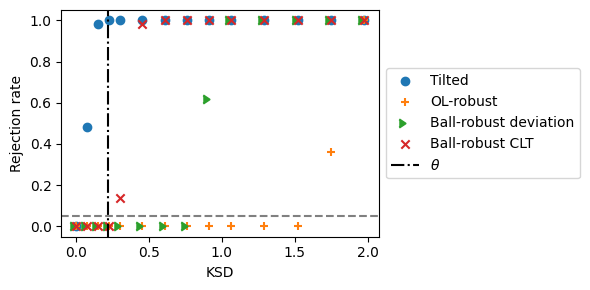

In [38]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in range(len(mean_ls))])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in range(len(mean_ls))])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in range(len(mean_ls))])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in range(len(mean_ls))])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in range(len(mean_ls))])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
# ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker="x") #, marker=6)
theta = res_ms[n][0]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

#### Power vs. dim

In [149]:
np.random.seed(2024)

n = 500
n_ls = [n]

dim_ls = [1, 5, 10, 20]
res_ms_dim = {"theta": [], "population_ksd": []}
for dim in dim_ls:
    print("dim:", dim)
    
    mean_scale_ls = [0.1, 0.2, 0.3, 0.4, 0.45, 0.5, 0.55, 0.6, 1., 5.]
    mean_ls = [np.ones((dim,)) * ss for ss in mean_scale_ls]
    
    # 1.estimate theta
    # 1.1 theoretical 
    theta = population_ksd_ms(mean_ls[5], bandwidth_sq=1.)
    # # 1.2 empirical ###
    # mean1 = np.zeros((dim,)) # data
    # mean2 = mean_ls[5]
    
    # XX = np.random.multivariate_normal(mean1, np.eye(dim), (2000,))
    # score_fn = lambda x: - (x - mean2)

    # score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
    # kernel0 = kernels.RBF(med_heuristic=True, X=XX, Y=XX)
    # kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
    # ksd = metrics.KSD(kernel, score_fn=score_fn)
    # theta = (ksd(XX, XX) + 0.01)**0.5
    # ###
    res_ms_dim["theta"].append(theta)
    res_ms_dim["population_ksd"].append([population_ksd_ms(mm) for mm in mean_ls])

    # 2. run experiment 
    res_ms_dim[dim] = rej_rate_meanshift(mean_ls=mean_ls, n_ls=n_ls, theta=theta, nreps=10, bw="med")

dim: 1
key: 0


  0%|          | 0/10 [00:00<?, ?it/s]

key: 1


  0%|          | 0/10 [00:00<?, ?it/s]

key: 2


  0%|          | 0/10 [00:00<?, ?it/s]

key: 3


  0%|          | 0/10 [00:00<?, ?it/s]

key: 4


  0%|          | 0/10 [00:00<?, ?it/s]

key: 5


  0%|          | 0/10 [00:00<?, ?it/s]

key: 6


  0%|          | 0/10 [00:00<?, ?it/s]

key: 7


  0%|          | 0/10 [00:00<?, ?it/s]

key: 8


  0%|          | 0/10 [00:00<?, ?it/s]

key: 9


  0%|          | 0/10 [00:00<?, ?it/s]

dim: 5
key: 0


  0%|          | 0/10 [00:00<?, ?it/s]

key: 1


  0%|          | 0/10 [00:00<?, ?it/s]

key: 2


  0%|          | 0/10 [00:00<?, ?it/s]

key: 3


  0%|          | 0/10 [00:00<?, ?it/s]

key: 4


  0%|          | 0/10 [00:00<?, ?it/s]

key: 5


  0%|          | 0/10 [00:00<?, ?it/s]

key: 6


  0%|          | 0/10 [00:00<?, ?it/s]

key: 7


  0%|          | 0/10 [00:00<?, ?it/s]

key: 8


  0%|          | 0/10 [00:00<?, ?it/s]

key: 9


  0%|          | 0/10 [00:00<?, ?it/s]

dim: 10
key: 0


  0%|          | 0/10 [00:00<?, ?it/s]

key: 1


  0%|          | 0/10 [00:00<?, ?it/s]

key: 2


  0%|          | 0/10 [00:00<?, ?it/s]

key: 3


  0%|          | 0/10 [00:00<?, ?it/s]

key: 4


  0%|          | 0/10 [00:00<?, ?it/s]

key: 5


  0%|          | 0/10 [00:00<?, ?it/s]

key: 6


  0%|          | 0/10 [00:00<?, ?it/s]

key: 7


  0%|          | 0/10 [00:00<?, ?it/s]

key: 8


  0%|          | 0/10 [00:00<?, ?it/s]

key: 9


  0%|          | 0/10 [00:00<?, ?it/s]

dim: 20
key: 0


  0%|          | 0/10 [00:00<?, ?it/s]

key: 1


  0%|          | 0/10 [00:00<?, ?it/s]

key: 2


  0%|          | 0/10 [00:00<?, ?it/s]

key: 3


  0%|          | 0/10 [00:00<?, ?it/s]

key: 4


  0%|          | 0/10 [00:00<?, ?it/s]

key: 5


  0%|          | 0/10 [00:00<?, ?it/s]

key: 6


  0%|          | 0/10 [00:00<?, ?it/s]

key: 7


  0%|          | 0/10 [00:00<?, ?it/s]

key: 8


  0%|          | 0/10 [00:00<?, ?it/s]

key: 9


  0%|          | 0/10 [00:00<?, ?it/s]

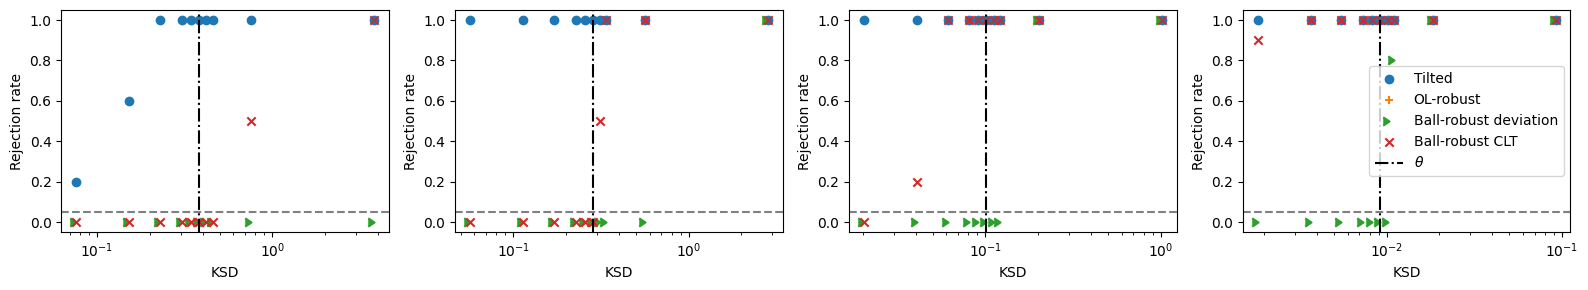

In [155]:
_, axes = plt.subplots(ncols=len(dim_ls), nrows=1, figsize=(4*len(dim_ls), 3))
axes = [axes] if len(dim_ls) == 1 else axes

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for i, ax in enumerate(axes):
    dim = dim_ls[i]
    rr = res_ms_dim[dim]

    for method, lab in methods.items():
        rej = np.array([np.mean(rr[n][kk][method]["rej"]) for kk in range(len(mean_ls))])
        ksd = np.array([np.mean(rr[n][kk][method]["rej"]) for kk in range(len(mean_ls))])
    
    rej_tilted = np.array([np.mean(rr[n][kk]["tilted"]["rej"]) for kk in range(len(mean_ls))])
    rej_rbf = np.array([np.mean(rr[n][kk]["rbf"]["rej"]) for kk in range(len(mean_ls))])
    rej_ol_robust = np.array([np.mean(rr[n][kk]["tilted_ol_robust"]["rej"]) for kk in range(len(mean_ls))])
    rej_ball_robust = np.array([np.mean(rr[n][kk]["tilted_ball_robust"]["rej"]) for kk in range(len(mean_ls))])
    rej_ball_clt = np.array([np.mean(rr[n][kk]["tilted_ball_clt"]["rej"]) for kk in range(len(mean_ls))])
    
    mean_ls = [np.ones((dim,)) * ss for ss in mean_scale_ls]
    ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
    ax.scatter(ksd_ls, rej_tilted, label="Tilted")
    ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
    ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
    ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker="x") #, marker=6)
    theta = rr[n][i]["tilted_ball_robust"]["theta"][0]
    ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
    ax.axhline(0.05, linestyle="--", color="grey")
    ax.set_xscale("log")
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel("KSD")
    ax.set_ylabel("Rejection rate")

# ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.legend()
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

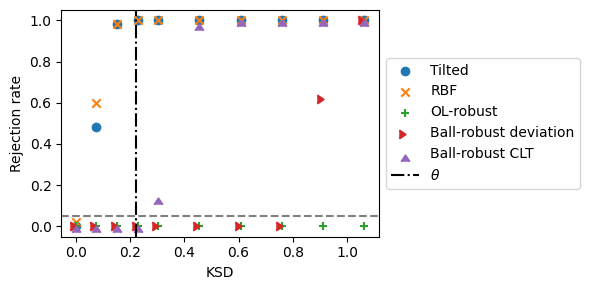

In [295]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 3))

methods = {"tilted": "Tilted", "rbf": "RBF", "tilted_ol_robust": "OL-robust", "tilted_ball_robust": "Ball-robust"}

for method, lab in methods.items():
    rej = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in mean_ls])
    ksd = np.array([np.mean(res_ms[n][kk][method]["rej"]) for kk in mean_ls])

rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in mean_ls])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in mean_ls])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in mean_ls])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in mean_ls])
rej_ball_clt = np.array([np.mean(res_ms[n][kk]["tilted_ball_clt"]["rej"]) for kk in mean_ls])

ksd_ls = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(ksd_ls, rej_tilted, label="Tilted")
ax.scatter(ksd_ls, rej_rbf, label="RBF", marker="x")
ax.scatter(ksd_ls, rej_ol_robust, label="OL-robust", marker="+")
ax.scatter(ksd_ls, rej_ball_robust, label="Ball-robust deviation", marker=5)
ax.scatter(ksd_ls, rej_ball_clt, label="Ball-robust CLT", marker=6)
theta = res_ms[n][mean_ls[0]]["tilted_ball_robust"]["theta"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.set_xlabel("KSD")
ax.set_ylabel("Rejection rate")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
# plt.savefig("../figs/robust/rej_ms.pdf")

key: 0


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 1


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

key: 2


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


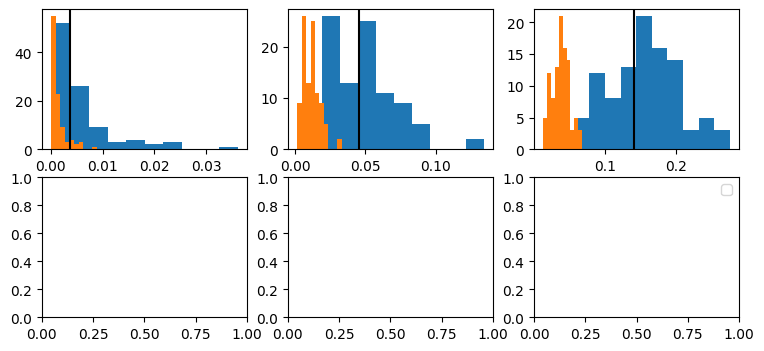

In [143]:
def check_jackknife(mean_ls, n, nreps, dim=1, alpha=0.05):
    res = {kk: {
        "jackknife": [],
        "standard": [],
        "oracle": [],
    } for kk in range(len(mean_ls))}
    res["mean_ls"] = mean_ls
    
    for i, mean in enumerate(mean_ls):
        key = i
        print("key:", key)
        ###
        mean1 = np.zeros((dim,)) # data
        mean2 = np.reshape([mean], (-1,)) # model
        
        Xs = np.random.multivariate_normal(mean1, np.eye(dim), (nreps, n))
    
        score_fn = lambda x: - (x - mean2)
        ###
        
        for X in tqdm(Xs):
            # tilted ball robust CLT
            score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
            ksd = metrics.KSD(kernel, score_fn=score_fn)

            # 1
            res[key]["jackknife"].append(ksd.jackknife(X, X))

            # 2
            u_mat = ksd(X, X, output_dim=2, vstat=True) # n x n
            witness = np.sum(u_mat, axis=1) / n # n
            term1 = np.sum(witness**2) / n
            term2 = (np.mean(u_mat))**2
            res[key]["standard"].append(term1 - term2 + 1e-12)

        # 3. oracle
        # X_ora = np.random.multivariate_normal(mean1, np.eye(dim), (5000,))
        # mm = np.mean(u_mat)
        # res[key]["oracle"] = np.mean((np.sum(u_mat, -1) / n- mm)**2)
        
        Xs_ora = np.random.multivariate_normal(mean1, np.eye(dim), (100, n))
        ksd_val_ls = []
        for X in tqdm(Xs_ora):
            score_weight_fn = kernels.PolyWeightFunction(loc=mean2)
            kernel0 = kernels.RBF(sigma_sq=2.)
            kernel = kernels.TiltedKernel(kernel=kernel0, weight_fn=score_weight_fn)
            ksd = metrics.KSD(kernel, score_fn=score_fn)
            ksd_val = ksd(X, X)
            ksd_val_ls.append(ksd_val)
        
        res[key]["oracle"] = np.var(ksd_val_ls) * n
            
    return res


np.random.seed(2024)
mean_ls = [0., 0.2, 0.4]
mean_ls = [np.reshape([mm], (-1,)) for mm in mean_ls]
var_res = check_jackknife(mean_ls=mean_ls, n=n, nreps=100)

_, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 4))
for i in range(len(mean_ls)):
    ax = axes.flatten()[i]
    _ = ax.hist(var_res[i]["jackknife"], label="jackknife")
    _ = ax.hist(var_res[i]["standard"], label="standard")
    ax.axvline(var_res[i]["oracle"], color="k", label="oracle")

plt.legend()

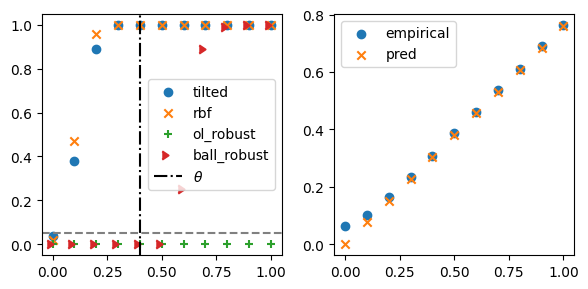

In [111]:
figs, axes = plt.subplots(ncols=2, nrows=1, figsize=(6, 3))

ax = axes[0]
rej_tilted = np.array([np.mean(res_ms[n][kk]["tilted"]["rej"]) for kk in mean_ls])
rej_rbf = np.array([np.mean(res_ms[n][kk]["rbf"]["rej"]) for kk in mean_ls])
rej_ol_robust = np.array([np.mean(res_ms[n][kk]["tilted_ol_robust"]["rej"]) for kk in mean_ls])
rej_ball_robust = np.array([np.mean(res_ms[n][kk]["tilted_ball_robust"]["rej"]) for kk in mean_ls])

ax.scatter(mean_ls, rej_tilted, label="tilted")
ax.scatter(mean_ls, rej_rbf, label="rbf", marker="x")
ax.scatter(mean_ls, rej_ol_robust, label="ol_robust", marker="+")
ax.scatter(mean_ls, rej_ball_robust, label="ball_robust", marker=5)
theta = res_ms[n][mean_ls[0]]["tilted_ball_robust"]["threshold"][0]
ax.axvline(theta, linestyle="-.", color="k", label=r"$\theta$")
ax.axhline(0.05, linestyle="--", color="grey")
# ax.set_xscale("log")
ax.set_ylim(-0.05, 1.05)
ax.legend()

ax = axes[1]
ksd_val = [np.mean(res_ms[n][kk]["rbf"]["stat"])**0.5 for kk in mean_ls]
ksd_val_pred = [population_ksd_ms(mm) for mm in mean_ls]
ax.scatter(mean_ls, ksd_val, label="empirical")
ax.scatter(mean_ls, ksd_val_pred, marker="x", label="pred")
# ax.set_xscale("log")
ax.legend()

plt.tight_layout()